In [1]:
from pytket_mbqc_py.qubit_manager import QubitManager
from pytket_mbqc_py.graph_circuit import GraphCircuit
from pytket_mbqc_py.wasm_file_handler import get_wasm_file_handler
from pytket.unit_id import BitRegister
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline
import networkx as nx
from pytket.circuit.display import render_circuit_jupyter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def create_path_graph_circuit(num_qubits: int):
    circuit = GraphCircuit(n_qubits_total=num_qubits)
    index_dict = {}

    for i in range(num_qubits):
        if i == 0:
            qubit_one, index_dict[f"index_{i}"] = circuit.add_input_vertex()
        elif i == num_qubits-1:
            index_dict[f"index_{i}"] = circuit.add_output_vertex()
        else:
            index_dict[f"index_{i}"] = circuit.add_graph_vertex()
    return circuit

In [57]:
def run_path_graph_n_qubits(num_qubits: int, number_shots: int):
    circuit = GraphCircuit(n_qubits_total=num_qubits)
    index_dict = {}

    for i in range(num_qubits):
        if i == 0:
            qubit_one, index_dict[f"index_{i}"] = circuit.add_input_vertex()
        elif i == num_qubits-1:
            index_dict[f"index_{i}"] = circuit.add_output_vertex()
        else:
            index_dict[f"index_{i}"] = circuit.add_graph_vertex()

    keys = list(index_dict.keys())

    for i in range(1, len(keys)):
        key_i = keys[i]
        key_i_minus_1 = keys[i - 1]
        vertex_i = index_dict[key_i]
        vertex_i_minus_1 = index_dict[key_i_minus_1]
        circuit.add_edge(vertex_i_minus_1, vertex_i)

    for i in range(len(keys)-1):   
        vertex_i = index_dict[keys[i]]
        circuit.corrected_measure(vertex=vertex_i)

    circuit.correct_outputs()
    output_reg = BitRegister(name="output", size=1)
    circuit.add_c_register(register=output_reg)
    circuit.Measure(qubit=circuit.output_qubits[num_qubits-1], bit=output_reg[0])

    api_offline = QuantinuumAPIOffline()
    backend = QuantinuumBackend(device_name="H1-1LE", api_handler=api_offline)
    compiled_circuit = backend.get_compiled_circuit(circuit)

    backend = QuantinuumBackend(
        device_name="H1-1LE", api_handler=QuantinuumAPIOffline()
    )
    compiled_circuit = backend.get_compiled_circuit(circuit)
    n_shots = number_shots

    result = backend.run_circuit(
        circuit=compiled_circuit,
        n_shots=n_shots,
        wasm_file_handler=get_wasm_file_handler(),
    )
    values = result.get_counts(output_reg).values()
    values_array = np.array(list(values))
    total = np.sum(values_array)
    data = values_array / total
    if num_qubits % 2 == 1:
        padded_data = np.array([data[0],0.0])
    elif num_qubits % 2 == 0:
        padded_data = np.array(data)
    else:
        raise ValueError("Invalid: not odd, nor even number of qubits")
    padded_data
    return padded_data


In [59]:
def square_difference(data):
    a,b = data
    return np.sum((a - b) ** 2)

In [8]:
def bar_plot_results(data):
    data.values()
    abs_diff = np.diff(data)**2

    # Create an array with the positions of each bar along the x-axis
    x_pos = np.arange(len(data))
    plt.bar(x_pos, data)
    tick_names = ['0', '1']
    plt.xticks(x_pos, tick_names)
    plt.xlabel('Outcome')
    plt.ylabel('P(Outcome)')    
    plt.title(f'Outcome probabilities square difference: {abs_diff}')
    plt.show()

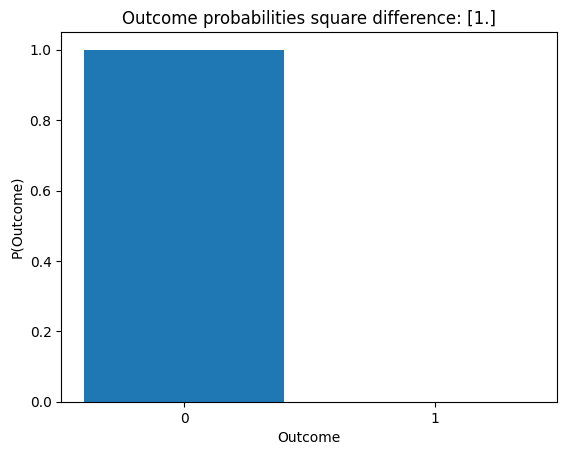

In [82]:
num_qubits = 5
data = run_path_graph_n_qubits(num_qubits = num_qubits, number_shots = 100)
bar_plot_results(data)


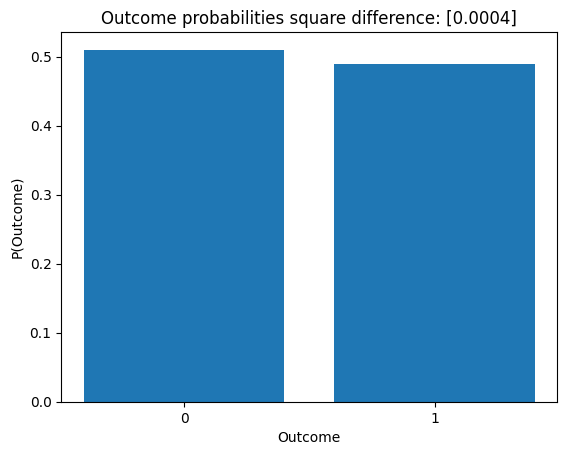

In [83]:
num_qubits = 6
data = run_path_graph_n_qubits(num_qubits = num_qubits, number_shots = 100)
bar_plot_results(data)

In [87]:
data_list = {}
for i in range(1,20):
    data = run_path_graph_n_qubits(i, 1000)
    data_list[i] = square_difference(data)

In [94]:
import statistics

# Your list of numbers
numbers = [1, 2, 3, 4, 5]

# Calculate the mean
mean = statistics.mean(numbers)

print(mean)  # Prints: 3.0

3


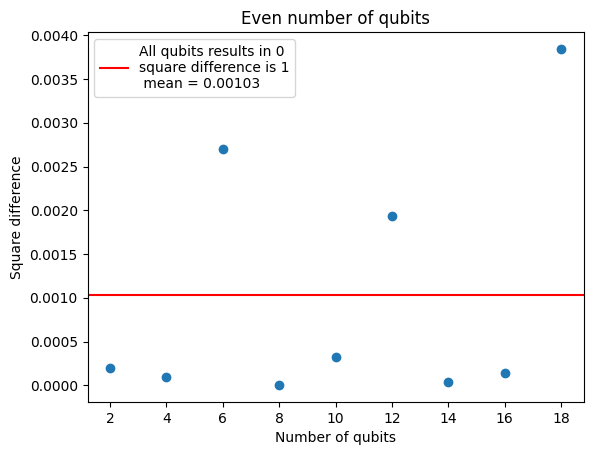

In [98]:
keys = []
values = []

# Iterate over the dictionary
for key, value in data_list.items():
    # Check if the key is even
    if key % 2 == 0:
        keys.append(key)
        values.append(value)
        
        
mean = statistics.mean(values)
mean = float(format(mean, '.3g')) 

# Create a scatter plot
plt.scatter(keys, values)
plt.axhline(mean, color='r',label=f'All qubits results in 0\nsquare difference is 1\n mean = {mean}')
plt.xlabel('Number of qubits')
plt.ylabel('Square difference')
plt.title('Even number of qubits')

# Show the plo
plt.legend()
plt.show()

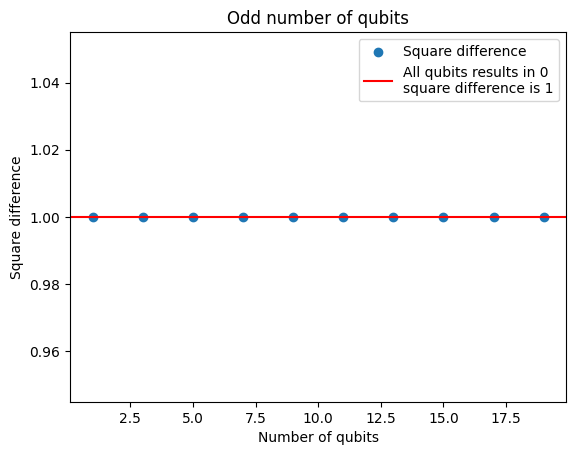

In [93]:
keys = []
values = []

# Iterate over the dictionary
for key, value in data_list.items():
    # Check if the key is even
    if key % 2 == 1:
        keys.append(key)
        values.append(value)

# Create a scatter plot
plt.scatter(keys, values,label='Square difference')
plt.axhline(1, color='r',label='All qubits results in 0\nsquare difference is 1')
plt.xlabel('Number of qubits')
plt.ylabel('Square difference')
plt.title('Odd number of qubits')

plt.legend()
plt.show()